In [5]:
import torch
from datasets import BitStringDataset, ECoGDataset
import lovely_tensors as lt
import wandb
import tqdm
from models import SkipConnectionSupervenientFeatureNetwork
from trainers import train_feature_network

lt.monkey_patch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

seed = 43
torch.manual_seed(seed)



In [18]:
# dataset = ECoGDataset()

# trainloader = torch.utils.data.DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

In [17]:
bits_dataset_config = {
    "num_data_points": int(1e6),
    "extra_bit_correlation": 0.99,
    "parity_bit_correlation": 0.99,
}


dataset = BitStringDataset(
    gamma_parity=bits_dataset_config['parity_bit_correlation'],
    gamma_extra=bits_dataset_config['extra_bit_correlation'],
    length=bits_dataset_config['num_data_points'],
)

trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=config['batch_size'],
    shuffle=True,
)

print("Dataset loaded")

Dataset loaded


In [22]:

config = {
    "torch_seed": seed,
    "dataset_type": "bits",
    "num_atoms": 6,
    "batch_size": 1000,
    "train_mode": True,
    "train_model_B": False,
    "adjust_Psi": False,
    "clip": 5,
    "feature_size": 1,
    "epochs": 20,
    "start_updating_f_after": 1000,
    "update_f_every_N_steps": 10,
    "minimize_neg_terms_until": 100000,
    "downward_critics_config": {
        "hidden_sizes_v_critic": [512, 512, 512, 256],
        "hidden_sizes_xi_critic": [512, 512, 512, 256],
        "critic_output_size": 32,
        "lr": 1e-3,
        "bias": True,
        "weight_decay": 0,
    },
    "decoupled_critic_config": {
        "hidden_sizes_encoder_1": [512, 1024, 512, 256],
        "hidden_sizes_encoder_2": [512, 1024, 512, 256],
        "critic_output_size": 32,
        "lr": 1e-3,
        "bias": True,
        "weight_decay": 0,
    },
    "feature_network_config": {
        "hidden_sizes": [256, 256, 256],
        "lr": 1e-5,
        "bias": True,
        "weight_decay": 0,
    }
}



import importlib
import trainers
importlib.reload(trainers)
from trainers import train_feature_network

feature_network = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_network_config']['hidden_sizes'],
    include_bias=config['feature_network_config']['bias'],
).to(device)

feature_network = train_feature_network(config, trainloader, feature_network)


Psi,▂▂▁▄▇█▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇█▇█▇▇▇▇▇█▇▇███
bonus_bit_MI,▆███▅▅▃▄▃▂▁▅▃▃▁▃▅▅▂▁▂▅▂▃▃▅▄▇▄█▂▇▄▃▇▇▆▄▅▂
decoupled_MI,▁▁▁▃████▇██▇███████████▇█▇████▇████▇▇███
extra_bit_MI,▃▅▅▅▄▃▃▅▄▃▂▅▄▅▃▁▅▅▃▃▃▅▁▄▅▄▄█▆▆▄▄▄▅▆▅▆▇█▆
feature_loss,▇▇█▅▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▂▁▂▂▂▂▂▁▂▂▁▁▁
sum_downward_MI,▁▁▆▄▅▃▄▅▅▄▄█▃▅▇▅▆█▅▃▅▆▂▄▄▄▂▄▃█▆██▄▂▃▂▂▂▂
xor_MI,▁▂▂▃▇▇██████████████████████████████████
Psi,0.6389
bonus_bit_MI,0.09463
decoupled_MI,0.64996
extra_bit_MI,0.11521


In [5]:
import importlib
import trainers
importlib.reload(trainers)
from trainers import train_feature_network

feature_network_A = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_network_config']['hidden_sizes'],
    include_bias=config['feature_network_config']['bias'],
    ).to(device)

model_A_path = '/vol/bitbucket/dm2223/info-theory-experiments/models/feature_network_apricot-pond-70.pth'
feature_network_A.load_state_dict(torch.load(model_A_path))

feature_network_B = SkipConnectionSupervenientFeatureNetwork(
    num_atoms=config['num_atoms'],
    feature_size=config['feature_size'],
    hidden_sizes=config['feature_network_config']['hidden_sizes'],
    include_bias=config['feature_network_config']['bias'],
).to(device)

feature_network_B = train_feature_network(config, trainloader, feature_network_B, feature_network_A)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<<Training model B>>


wandb: Currently logged in as: dmcsharry. Use `wandb login --relogin` to force relogin


Training: 100%|██████████| 20/20 [09:38<00:00, 28.93s/it]


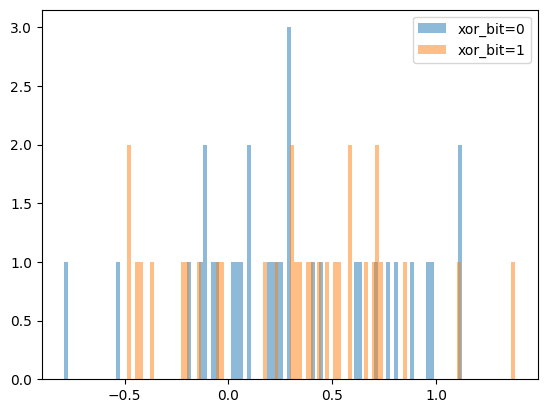

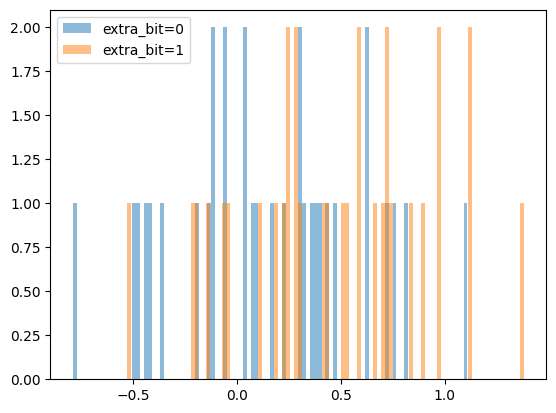

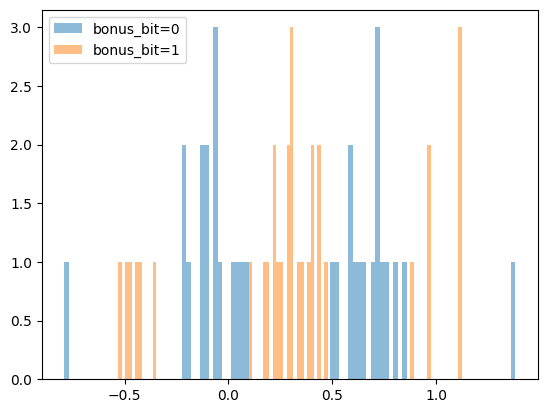

In [7]:
from einops import reduce
import numpy as np

feature_network = feature_network_B

# plot the various values of V to visually inspect if they contain information about the different bits


binary_numbers = torch.tensor([[int(bit) for bit in f"{i:06b}"] for i in range(2**6)])

v = feature_network(binary_numbers.float().to(device))

xor_bits = (reduce(binary_numbers[:, :5], 'b n -> b', 'sum') % 2).unsqueeze(1)

# plot the different values of v on a histogram, with different colors for the two different xor bits

import matplotlib.pyplot as plt
import numpy as np

v_np = v.detach().cpu().numpy()
xor_bits_np = xor_bits.cpu().numpy()

plt.hist(v_np[xor_bits_np == 0], bins=100, alpha=0.5, label='xor_bit=0')
plt.hist(v_np[xor_bits_np == 1], bins=100, alpha=0.5, label='xor_bit=1')
plt.legend()
plt.show()


extra_bits = binary_numbers[:, -1].unsqueeze(1)

# plot the different values of v on a histogram, with different colors for the two different extra bits


plt.hist(v_np[extra_bits == 0], bins=100, alpha=0.5, label='extra_bit=0')
plt.hist(v_np[extra_bits == 1], bins=100, alpha=0.5, label='extra_bit=1')
plt.legend()
plt.show()


bonus_bits = ( xor_bits + extra_bits ) % 2

# plot the different values of v on a histogram, with different colors for the two different bonus bits


plt.hist(v_np[bonus_bits == 0], bins=100, alpha=0.5, label='bonus_bit=0')
plt.hist(v_np[bonus_bits == 1], bins=100, alpha=0.5, label='bonus_bit=1')
plt.legend()
plt.show()



In [15]:
# random float tensor

t = torch.rand(1).to(device)
print(t)
print(t.item())
print(type(t.item()))


# convert to half precision

t_half = t.half()
print(t_half)
print(t_half.item())
print(type(t_half.item()))

# convert to float

t_float = t_half.float()
print(t_float)
print(t_float.item())
print(type(t_float.item()))




tensor[1] cuda:0 [0.104]
0.10377240180969238
<class 'float'>
tensor[1] f16 cuda:0 [0.104]
0.103759765625
<class 'float'>
tensor[1] cuda:0 [0.104]
0.103759765625
<class 'float'>
